# 모바일 게임  쿠키캣과 A/B 테스트: 첫번째 게이트를 레벨 30 또는 레벨 40에? 


### < 프로젝트 소개 >
쿠키캣은 택타일 엔터테인먼트사가 만든 큰인기를 받고 잇는 모바일 퍼즐 게임이다. 같은 색의 세개의 타일을 연결하면 판이 깨지고 레벨이 올라가고 노래하는 고양이 나오는 게임이다.
게임이 진행되면 게이트가 나오는데 이 게이트에서 다음 레벨로 넘어가기 까지 기다리거나 in-app 구입을 해야 한다. 이 프로젝트에서는 A/B 테스트를 통해 첫번째 게이트를 레벨 30에서 40으로 옮긴 결과를 분석할 것이고 리텐션과 게임 라운드(판수)의 관점에서 분석할 것이다.
분석할 데이터는 90,189 게임유저들로 얻은 것이다.


### < 변수 설명 >
- userid - 게임 유저 아이디
- version - 유저가 통제그룹(gate_30 - 게이트가 레벨 30에 있음) 또는 실험그룹(gate_40 - 게이트가 레벨 40에 있음)에 있는지 여부
- sum_gamerounds - 게임앰 설치 후 일주일간 유저가 플레이한 게임 판수
- retention_1 - 설치 1일 후 유저가 돌아왔는가?
- retention_7 - 설치 7일 후 유저가 돌아왔는가?

유저가 게임을 설치하면, gate_30 또는 gate_40 버전이 무작위로 설치된다.




### < 테스트 진행방법>
#### 통제 또는 실험 그룹과 가설을 정의한다
- Control group (A): 첫번째 게이트가 레벨 30에 위치해 있는 유저 그룹
- Test group (B): 첫번째 게이트가 레벨 40에 위치해 있는 유저 그룹
- H0: A와 B 그룹은 유사하다. (= 게이트를 레벨 30에서 40으로 이동한 것은 게임 판수에 영향을 주지 않는다)
- H1: A와 B 그룹은 다르다. (= 게이트를 레벨 30에서 40으로 이동한 것은 게임 판수에 영향 준다.)


#### 가정:
- 정규성을 확인하고 정규분포이면 동질성을 확인한다.

#### 순서:
- 통제 및 실험 그룹으로 나누고 정의한다.
- 정규성 확인을 위해 샤피로 테스트를 실행한다.
- 만약 모수적 방법(정규분포) 적용할 수 있다면 분산의 동질성 확인을 위해 Levene Test 실행
- 모수적이고 + 분산이 동질하다면, T-Test를 적용
- 모수적이고 + 분산이 동질하지 않다면, Welch Test를 적용
- 비모수적이라면, Mann Whitney U Test를 적용


### < 목차 >
1. Libraries
2. Import Data
3. Summary Stats
4. Outliers
5. Some Details
6. A/B Testing
7. Conclusion

#### 참고:
https://www.kaggle.com/code/ekrembayar/a-b-testing-step-by-step-hypothesis-testing

# 1. Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io

from scipy.stats import shapiro
import scipy.stats as stats

import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

mpl.rc('font', family='NanumGothic')
mpl.rc('axes', unicode_minus=False)

%matplotlib inline

# 2. Import Data

데이터를 임포트하면서, 각 데이터타입의 수와 속성을 알아보고 이를 아래와 같이 맞춤화된 표로 나타낸다.

In [2]:
def load(data, info=True):
    read = pd.read_csv(data)
    if info:
        if len(read) > 0:
            print('# Data imported!')
            print('# ------------------------------------', '\n')
            print('# DIMENSIONS -------------------------')
            print('Observations:', read.shape[0], 'Columns:', read.shape[1],'\n')
            if len(read.select_dtypes('object').columns) > 0:
                print('Object Variables:', '\n', '# of Variables:', 
                      len(read.select_dtypes('object').columns), '\n',
                      read.select_dtypes('object').columns.tolist(),'\n')
            if len(read.select_dtypes('integer').columns) > 0:
                    print('Integer Variables:', '\n', '# of Variables:', 
                          len(read.select_dtypes('integer').columns), '\n',
                          read.select_dtypes('integer').columns.tolist(),'\n')
            if len(read.select_dtypes('float').columns) > 0:
                    print('Float Variables:', '\n', '# of Variables:', 
                          len(read.select_dtypes('float').columns), '\n',
                          read.select_dtypes('float').columns.tolist(),'\n')
            if len(read.select_dtypes('bool').columns) > 0:
                    print('Boolean Variables:', '\n', '# of Variables:', 
                          len(read.select_dtypes('bool').columns),
                          read.select_dtypes('bool').columns.tolist(),'\n')


            print('# MISSING VALUE ----------------------------', '\n')
            print('Are there any missing values?:', np.where(
                read.isnull().values.any() == False, 'No missing value!', 'Data including missing values!'), '\n')

            buf = io.StringIO()
            read.info(buf=buf)
            info = buf.getvalue().split('\n')[-2].split(':')[1].strip()
            print('# MEMORY USAGE-----------------------------\n', info)

    else:
        print('Data did not import!')

    return read

In [3]:
ab = load('cookie_cats.csv', info=True)
ab.head()

# Data imported!
# ------------------------------------ 

# DIMENSIONS -------------------------
Observations: 90189 Columns: 5 

Object Variables: 
 # of Variables: 1 
 ['version'] 

Integer Variables: 
 # of Variables: 2 
 ['userid', 'sum_gamerounds'] 

Boolean Variables: 
 # of Variables: 2 ['retention_1', 'retention_7'] 

# MISSING VALUE ---------------------------- 

Are there any missing values?: No missing value! 

# MEMORY USAGE-----------------------------
 2.2+ MB


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# 3. Summary Stats

위에서 보는 것처럼, 행의 수가 유저 아이디의 수와 동일한데, 이는 유저아이디에 중복된 값이 없다는 뜻으로 볼 수 있다.

In [4]:
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[['sum_gamerounds']].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,49854.0000


In [5]:
ab.groupby('version').sum_gamerounds.agg(['count', 'median', 'mean', 'std', 'min', 'max'])

,count,median,mean,std,min,max
version,,,,,,
gate_30,44700,17.0000,52.4563,256.7164,0,49854
gate_40,45489,16.0000,51.2988,103.2944,0,2640


99% 백분위는 493으로 평균값이 52보다 아주 크지 않아 제거할 이상치로 maximum value를 선택, 제거한다.

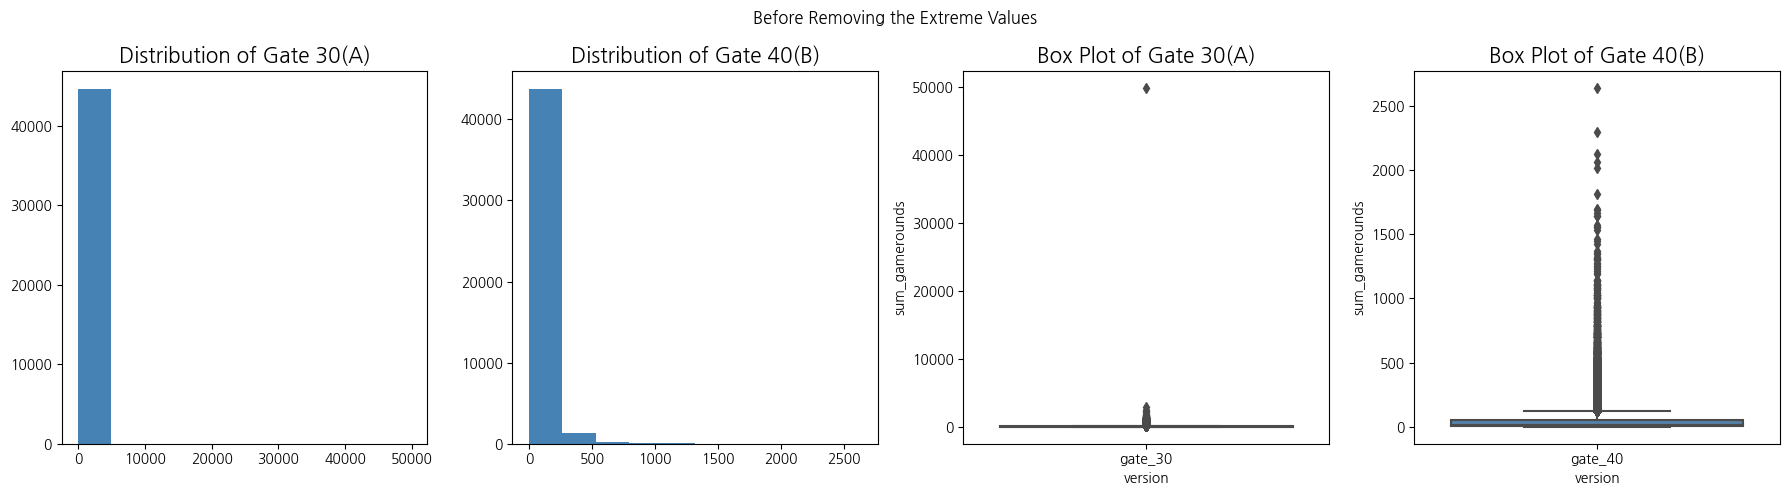

In [6]:
a = ab[ab.version == 'gate_30']
b = ab[ab.version == 'gate_40']

fig, axes = plt.subplots(1, 4, figsize=(18,5))

axes[0].hist(x=a.sum_gamerounds, color='steelblue')
axes[1].hist(x=b.sum_gamerounds, color='steelblue')
sns.boxplot(x=a.version, y=a.sum_gamerounds, ax=axes[2], color='steelblue')
sns.boxplot(x=b.version, y=b.sum_gamerounds, ax=axes[3], color='steelblue')

plt.suptitle('Before Removing the Extreme Values')
axes[0].set_title('Distribution of Gate 30(A)', fontsize=15)
axes[1].set_title('Distribution of Gate 40(B)', fontsize=15)
axes[2].set_title('Box Plot of Gate 30(A)', fontsize=15)
axes[3].set_title('Box Plot of Gate 40(B)', fontsize=15)

plt.tight_layout()
plt.show()

위의 세번째 그래프에서 보는 것처럼 maximum value가 크게 튀고 있어 제거해야 할 필요가 있다.

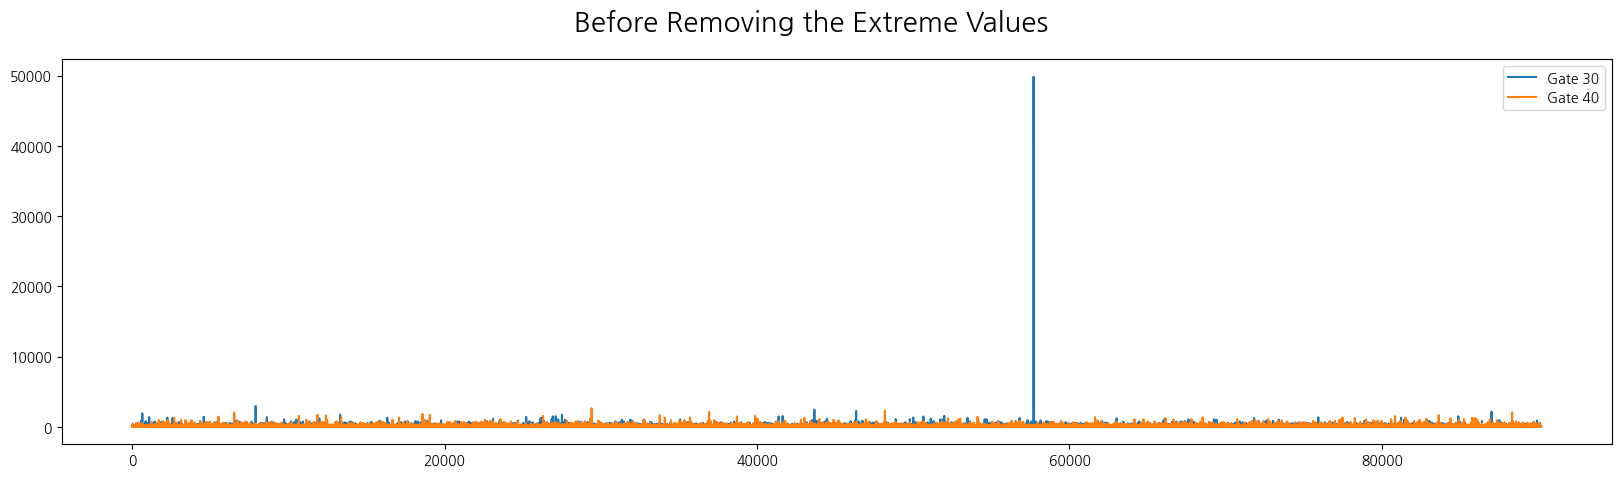

In [7]:
plt.figure(figsize=(20,5))

a.sum_gamerounds.plot(label='Gate 30')
b.sum_gamerounds.plot(label='Gate 40')

plt.suptitle('Before Removing the Extreme Values', fontsize=20)
plt.legend(loc=0)
plt.show()

# 4. Outliers

In [8]:
# Remove the outlier and see how its value distribution changes.
ab = ab[ab.sum_gamerounds < ab.sum_gamerounds.max()]
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[['sum_gamerounds']].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0000,51.3203,102.6827,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,2961.0000


In [9]:
ab.sum_gamerounds.max()

2961

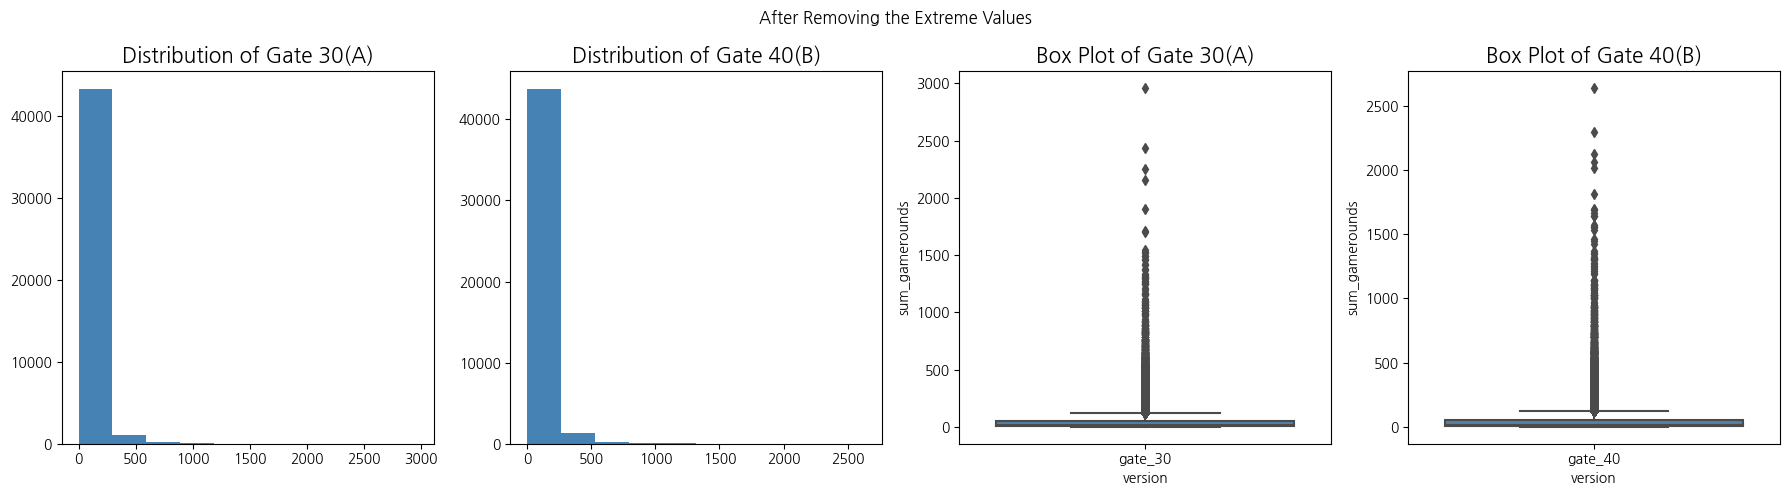

In [10]:
a = ab[ab.version == 'gate_30']
b = ab[ab.version == 'gate_40']

fig, axes = plt.subplots(1, 4, figsize=(18,5))

axes[0].hist(x=a.sum_gamerounds, color='steelblue')
axes[1].hist(x=b.sum_gamerounds, color='steelblue')
sns.boxplot(x=a.version, y=a.sum_gamerounds, ax=axes[2], color='steelblue')
sns.boxplot(x=b.version, y=b.sum_gamerounds, ax=axes[3], color='steelblue')

plt.suptitle('After Removing the Extreme Values')
axes[0].set_title('Distribution of Gate 30(A)', fontsize=15)
axes[1].set_title('Distribution of Gate 40(B)', fontsize=15)
axes[2].set_title('Box Plot of Gate 30(A)', fontsize=15)
axes[3].set_title('Box Plot of Gate 40(B)', fontsize=15)

plt.tight_layout()
plt.show()

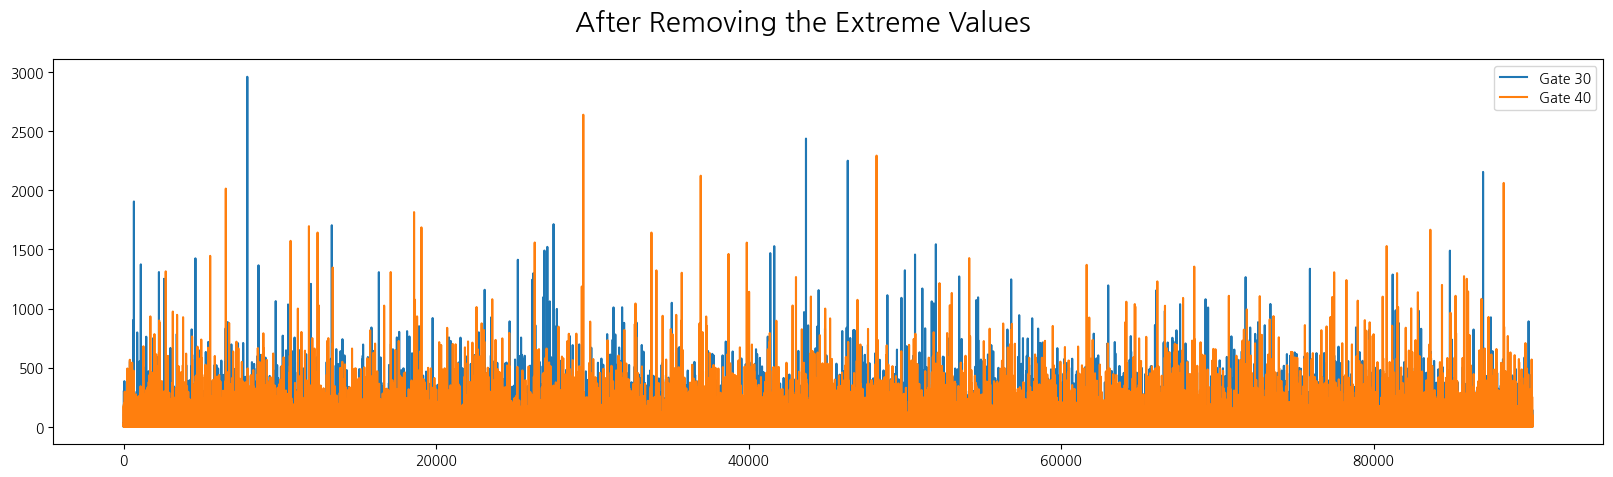

In [11]:
plt.figure(figsize=(20,5))

a.sum_gamerounds.plot(label='Gate 30')
b.sum_gamerounds.plot(label='Gate 40')

plt.suptitle('After Removing the Extreme Values', fontsize=20)
plt.legend(loc=0)
plt.show()

이상치 제거 후 그래프의 선의 분포가 훨씬 더 뚜렷하게 보인다. 제거 전에는 이상치 값으로 인해 선의 분포가 납작하고 단조로웠었다.

# 5. Some Details

A/B 테스트를 하기 전 게임 판수에 대한 유저수가 몇명이나 있는지에 대해 그래프를 통해 살펴보고자 한다. 이를 통해 게임판수가 진행됨에 따른 유저의 행동 패턴과 그리고 게임 설치 직후 유저가 게임을 하는지 여부도 알 수 있다.

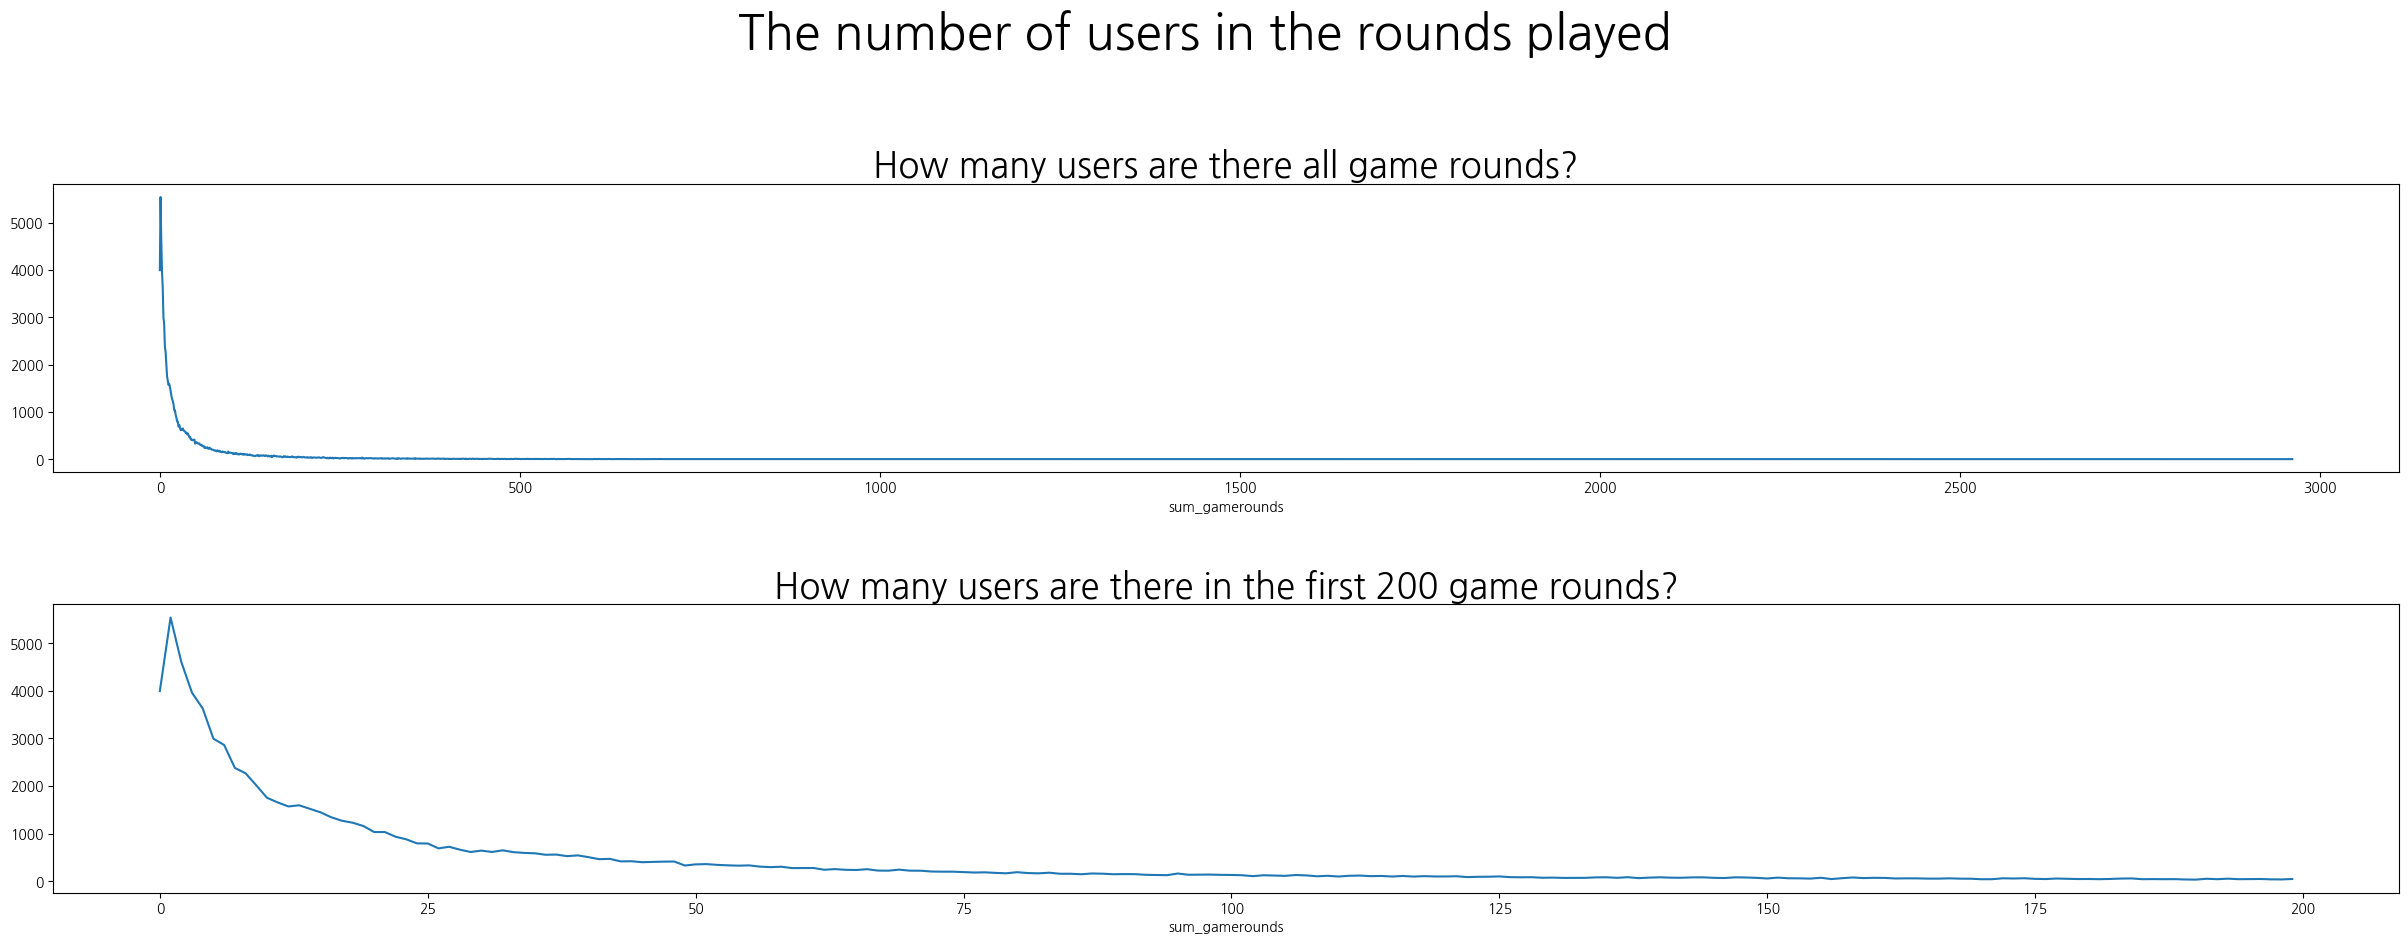

In [12]:
fig, axes = plt.subplots(2,1, figsize=(25, 10))

ab.groupby('sum_gamerounds').userid.count().plot(ax=axes[0])
axes[0].set_title('How many users are there all game rounds?', fontsize=25)

ab.groupby('sum_gamerounds').userid.count()[:200].plot(ax=axes[1])
axes[1].set_title('How many users are there in the first 200 game rounds?', fontsize=25)

plt.suptitle('The number of users in the rounds played', fontsize=35)
plt.tight_layout(pad=4)
plt.show()

In [13]:
# How many users never played the game?
ab.groupby('sum_gamerounds').userid.count()[0]

3994

In [14]:
# Homw many users played from 0 to 200 games rounds? 
# And what is its percentage out of the total users?
game200 = ab.groupby('sum_gamerounds').userid.count()[:200].sum()
game200_percent = game200 / len(ab)
game200, game200_percent

(84917, 0.9415554175721825)

#### 앱 설치 후 게임을 단 한번도 하지 않은 유저가 있다
- 약 3994명의 유저가 게임 설치 후 게임을 한번도 하지 않았다. 이것에 대한 이유를 찾아서 앱을 이미 설치한 게임유저를 실제로 게임을 할 수 방법을 강구할 필요가 있다. acquistion rates을 계산할 때 앱 설치 여부만 고려하기 때문에 쉽게 게임 설치 후 게임 실행하지 않는 문제는 간과되기 쉽기 때문에 이 문제를 살펴 보는 것이 좋을 것 같다.
- 게임 설치 후 플레이를 하지 않는 이유를 생각해 보면 이와 같다. 게임 설치 후 UX 내에서 게임 실행으로 이동하는 것이 분명하지 않고 헷갈리게 되어 있다. 또는 무료 체험 구독이나 특별한 게임 아이템을 제공하는 프로모션을 하고 있는 게임으로 유저가 이동한 것일 수 있다. 또는 그냥 유저가 게임을 할 시간이 없었다 등의 이유흘 생각해 볼 수 있다.

#### 게임 레벨이 올라갈 수록 게임을 하는 유저의 수가 줄어든다
- 약 94%의 유저가 0에서 200판의 게임을 했다. 대부분의 게임 유저들이 게임의 초반에서 게임을 그만두었고 게임의 레벨이 올라감에 따라 유저수는 급격히 감소하였다. 리텐션 비율을 올리기 위해 좀더 연구를 하거나 정보를 수집할 필요가 있다. 또한 게임의 난이도 또한 살펴볼 필요가 있다. 또는 무료 기프트를 주는 방법도 생각해 볼 수 있다.

레벨 30과 40에 도달하고 그 이상을 게임을 한 유저의 수는 각 버전별 얼마나 될까? 각 버전마다 그 수에 차이가 있을까?

In [15]:
# Calculate the number of users who reached level 30 and above and level 40 and above for the gate 30 version
user_counts_for_gate30 = a.groupby(['sum_gamerounds']).userid.count()
user_counts_for_gate30.loc[30:].sum(), user_counts_for_gate30.loc[40:].sum()

(16655, 13565)

In [16]:
# Calculate the number of users who were assigned the gate 40 verison
# Also, calculate the number of users who reached level 40 and above for the gate 30 version
user_counts_for_gate40 = b.groupby(['sum_gamerounds']).userid.count()
user_counts_for_gate40.loc[30:].sum(), user_counts_for_gate30.loc[40:].sum()

(16613, 13565)

두 버전의 리텐션 비율이 아주 유사함을 알 수 있으며 버전 게이트 40이 더 많은 유저를 유입하게 했다고 보기 어렵다.

A/B 테스틀를 진행하기전 두 버전의 숫자들을 살펴 보자.

Now again, before running a/b testing, we will be looking into each version to find how statistically different they are.

In [17]:
# A/B groups & target summary stats
ab.groupby('version').sum_gamerounds.agg(['count','median', 'mean','std','max'])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0000,51.3421,102.0576,2961
gate_40,45489,16.0000,51.2988,103.2944,2640


In [18]:
# What are the average retentions for 1 day and 7 days after installation?
pd.DataFrame({'true_count': [len(ab[ab.retention_1 == True]), len(ab[ab.retention_7 == True])],
              'true_ratio': [len(ab[ab.retention_1 == True])/len(ab), len(ab[ab.retention_7 == True])/len(ab)] },
            index=['retention_1', 'retention_7'])

,true_count,true_ratio
retention_1,40153,0.4452
retention_7,16780,0.1861


약 45%의 유저가 게임 설치 1일 후 다시 돌아 온 반면, 19%의 유저만이 게임 설치 7일 후 돌아 왔다.

In [19]:
# What are the average retentions for the gate 30 version?
a = ab[ab.version == 'gate_30']

pd.DataFrame({'true_count': [len(a[a.retention_1 == True]), len(a[a.retention_7 == True])],
              'true_ratio': [len(a[a.retention_1 == True])/len(a), len(a[a.retention_7 == True])/len(a)] },
            index=['retention_1', 'retention_7'])

,true_count,true_ratio
retention_1,20034,0.4482
retention_7,8501,0.1902


In [20]:
# What are the average retentions for the gate 40 version?
b = ab[ab.version == 'gate_40']
pd.DataFrame({'true_count': [len(b[b.retention_1 == True]), len(b[b.retention_7 == True])],
              'true_ratio': [len(b[b.retention_1 == True])/ len(b), len(b[b.retention_7 == True])/len(b)]},
            index=['retention_1', 'retention_7'])

,true_count,true_ratio
retention_1,20119,0.4423
retention_7,8279,0.1820


게이트 30과 40 버전의 평균 리텐션 비율을 비교하면 둘다 유사함을 알 수 있다.

In [21]:
# What is the average games for each version according to whether they came back for day 1 and day 7?
ab['NewRetention'] = list(map(lambda x,y: str(x) + '-' + str(y), ab.retention_1, ab.retention_7))
ab.groupby(['version', 'NewRetention']).sum_gamerounds.agg(['count', 'median', 'mean', 'std', 'max'])

count   median     mean      std   max
version NewRetention                                        
gate_30 False-False   22840   6.0000  11.8197  21.6426   981
        False-True     1825  43.0000  73.1693  93.2223  1072
        True-False    13358  33.0000  49.6945  58.1254   918
        True-True      6676 127.0000 183.8863 189.6264  2961
gate_40 False-False   23597   6.0000  11.9133  20.9010   547
        False-True     1773  47.0000  75.2611  94.4780  1241
        True-False    13613  32.0000  50.0255  60.9246  2640
        True-True      6506 133.0000 190.2824 194.2201  2294

게임 설치 1일, 7일 후 모두 게임에 돌아온 유저만을 리텐션을 계산했을 때, 게이트 40 버전의 평균 게임 수가 게이트 30보다 좀더 높음을 알 수 있다. 위의 표를 좀더 간단하게 만들어 보자.

In [22]:
# Count retentions only when users came back for both the two days.  If they did, put in 1 and if not, put in 0.
ab['Retention'] = np.where((ab.retention_1 == True) & (ab.retention_7 == True), 1, 0)
ab.groupby(['version', 'Retention'])['sum_gamerounds'].agg(['count', 'median', 'mean', 'std', 'max'])

count   median     mean      std   max
version Retention                                        
gate_30 0          38023  12.0000  28.0703  48.0175  1072
        1           6676 127.0000 183.8863 189.6264  2961
gate_40 0          38983  12.0000  28.1034  48.9278  2640
        1           6506 133.0000 190.2824 194.2201  2294

- 위의 표에서 처럼, 게이트 40 버전의 게임 판수는 190으로 게이트 30 버전의 수 184보다 6 게임 정도 높다. 게임 설치 1일 후와 7일 후 모두 유저가 돌아 왔을 때를 리텐션으로 볼 때, 게이트 40버전이 좀 더 유저를 유지하는 데 유리하다고 볼 수 있다. 

# 6. A/B Testing

In [23]:
# Define A/B groups
ab.version = np.where(ab.version == 'gate_30', 'A', 'B')
ab.head()

,userid,version,sum_gamerounds,retention_1,retention_7,NewRetention,Retention
0,116,A,3,False,False,False-False,0
1,337,A,38,True,False,True-False,0
2,377,B,165,True,False,True-False,0
3,483,B,1,False,False,False-False,0
4,488,B,179,True,True,True-True,1


In [24]:
# A/B testing fuction  - quick solution
def AB_Test(dataframe, group, target):
    
    # Pachages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == 'A'][target]
    groupB = dataframe[dataframe[group] == 'B'][target]
    
    # Assumption: normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is normal! - False
    # H1: Distribution is not normal - True
    
    if (ntA == False) & (ntB == False): # H0: Normal distribution
        # Parametric Test
        # Assumption: Homogeneity of variances
        LeveneTest = stats.leven(groupA, groupB)[1] < 0.05
        # H0: Homogeneous: False
        # H1: Heterogeneous: True
        
        if LevenTest == False:
            # Homogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var = True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 = True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var = False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1]
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({'AB Hypothesis':[ttest < 0.05], 'p-value':[ttest]})
    temp['Test Type'] = np.where((ntA == False) & (ntB == False), 'Parametric',
                                 'Non-Parametric')
    temp['AB Hypothesis'] = np.where(temp['AB Hypothesis'] == False, 'Fail to Reject H0',
                                    'Reject H0')
    temp['Comment'] = np.where(temp['AB Hypothesis'] == 'Fail to Reject H0',
                              'A/B  groups are similar!', 'A/B groups are not similar')
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp['Homogeneity'] = np.where(LevenTest == False, 'Yes', 'No')
        temp = temp[['Test Type', 'Homogeneity', 'AB Hypothesis', 'p-value', 'Comment']]
    else:
        temp = temp[['Test Type', 'AB Hypothesis', 'p-value', 'Comment']]
        
    # Print hypothesis
    print('# A/B Testing Hypothesis')
    print('H0: A == B')
    print('H1: A != B', '\n')
    
    return temp

# Apply A/B Testing
AB_Test(dataframe = ab, group = 'version', target = 'sum_gamerounds')

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.0509,A/B groups are similar!


# 7. Conclusion

우리는 A/B 테스트를 진행하기 전 우선, 누락된 값이 있는지 그리고 이상치가 있는 지를 먼저 살펴보고, maximum value를 제거함으로써 이상치를 처리하였다. 또한 게임 레벨이 올라감에 따른 유저 수를 살펴보고 유저들의 행동 패턴과 (게임 레벨이 올라감에 따라 유저의 수가 현저히 감소하였다) 앱 설치 후 게임을 전혀 하지 않는 문제도 살펴 보고 이에 대한 잠정적인 원인도 생각해 보았다.

A/B 테스트의 결과에 대해 살펴 보자. 샤피로 테스트가 귀무가설을 기각함에 따라 A/B 그룹은 정규 분포가 아님을 알 수 있었다. 따라서 t-test의 종류로 Mann Whitney U Test 를 적용하였다. 그리고 Mann Whitney U Test 또한 귀무가설을 기각하였다.

#### 이것은 결론적으로 A/B가 유의미한 수준에서 다르지 않음을 알 수 있었다.  다른 말로 첫번째 게이트를 레벨 30에서 40으로 옮기는 것은 유저가 하는 게임 판수에 영향을 주지 않으면 유저의 수를 늘리는데 유리하다고 말하기 어려움을 알 수 있다.

#### 어떤 버전이 리텐션 관점에서 더 유리하다고 볼 수 있을까?
A/B 테스트는 유저가 하는 게임 판수의 관점에서 이뤄졌는데, 리텐션 관점에서는 어는 버전이 유리할까? 리텐션 또한 중요한 지수로 이에 대한 분석도 의미있는 일이지만 현재 잇는 정보와 데이터로는 어떤 결론을 내기 어려울 것 같다. 게이트 30의 리텐션 비율이 게이트 40버전보다 아주 약간 높긴 하지만 게이트 30 버전이 더 유리하다는 결론을 내기에는 어렵다.

In [25]:
ab.groupby('version').retention_1.mean(), ab.groupby('version').retention_7.mean()

(version
 A   0.4482
 B   0.4423
 Name: retention_1, dtype: float64,
 version
 A   0.1902
 B   0.1820
 Name: retention_7, dtype: float64)